# Social Learning Under Randomized Collaborations

The following code pertains to the numerical simulations in the work [1], accepted for publication in ISIT 2022, Helsinki. An open access version is in https://arxiv.org/pdf/2201.10957.pdf.

## Introduction

Social learning is a paradigm where agents collaboratively seek to find the true state-of-nature. It can also be seen as an instance of a distributed hypothesis testing problem, where each agent partially observes the environment. In standard social learning algorithms, agents collaborate with all their neighbors at every time instant. We study a variant of the well-known diffusion algorithm, where at each time instant agents communicate with *only one randomly chosen neighbor*. Despite the amount of decrease in communication, it is shown in [1] that the agents learn the truth eventually and at the same rate as the standard algorithms.

## Problem Formulation

Among a set of $H$ hypotheses $\{\theta_1,\dots,\theta_H\}$, agents aim to infer the true hypothesis. The belief $\mu_{k,i} (\theta)$ quantifies the confidence that agent $k$ has at time $i$ in the proposition "$\theta$ is the true hypothesis". $\mu_{k,i}$ is a $H$-dimensional probability vector. Agent $ k $ observes $\mathbf{\xi}_{k,i} $ at time $ i $, which is distributed according to $ L_{k} (\mathbf{\xi}_{k,i}| \theta^\circ) $. Agent $ k $ knows its likelihood functions $ L_{k} (\cdot | \theta) $ for all $ \theta \in \Theta $. Data is independent and identically distributed (i.i.d.) across time.

## The Algorithm

1-Agent $k$ performs local updates to obtain intermediate beliefs:

\begin{align}\label{eq:dif_adapt_step}
 \mathbf{\psi}_{k,i} (\theta) &= \frac{L_k(\mathbf{\xi}_{k,i} | \theta)\mathbf{\mu}_{k,i-1} (\theta)}{\sum_{\theta^\prime}L_k(\mathbf{\xi}_{k,i} | \theta^\prime)\mathbf{\mu}_{k,i-1} (\theta^\prime)}. \qquad \text{(Adapt)}
\end{align}

2-Then chooses one of their neighbors with probability $\alpha_{\ell k}$ and averages its belief with the neighbors'

\begin{align}\label{eq:dif_combine_step}
   \mathbf{\mu}_{k,i}(\theta) &= \frac{\mathbf{\psi}_{k,i}(\theta)^\alpha \mathbf{\psi}_{\ell,i}(\theta)^{\bar\alpha} }{\sum_{\theta'}\mathbf{\psi}_{k,i}(\theta')^\alpha \mathbf{\psi}_{\ell,i}(\theta')^{\bar\alpha}} \text{, with prob. $a_{\ell k}$ (Combine)}
\end{align}

where $ \alpha \in [0,1)$ is a confidence weight and $\bar\alpha \triangleq 1-\alpha$. We assume the matrix $A := [a_{\ell k}]$ is primitive. Denote its Perron vector by $\pi$.

## Results

Theorem 1 (Asymptotic Convergence Rate):
Let $\theta^\circ$ be the true hypothesis and $\mathbf{\lambda}_{k,i}(\theta) := \log\frac{\mathbf{\mu}_{k,i}(\theta^\circ)}{\mathbf{\mu}_{k,i}(\theta)}$. Let $d_k(\theta) := D(L_k(.|\theta^{\circ}) || L_k(.|\theta)) < \infty$ Then for all $k$,
\begin{equation}\tfrac 1 i \mathbf{\lambda}_{k,i}(\theta) \to \sum_k \pi_kd_k(\theta) 
\end{equation}
almost surely.

### Special Case of Replacement

When $\alpha = 0$, agents replace their beliefs with their neighbors'. The above theorem still holds and furthermore, we carry out a large deviations analysis. The analysis only depends on the marginal distribution of data across agents, i.e., $L_k(.|\theta)$ thanks to the replacement procedure. For general case, one needs the knowledge of the joint distribution.

Theorem 2: Let $\mathbf{x}_{\ell} := \log\frac{L_k(\mathbf{\xi}_1|\theta^{\circ})}{L_k(\mathbf{\xi}_1|\theta)}$.  Set $A(t) := \big[a_{\ell k}E[e^{t\mathbf{x}_{\ell}}]\big]$ and let $\Lambda(t)$ be the Perron-Frobenius eigenvalue of $A(t)$. Then for any $\Gamma \subseteq \mathbb{R}$,
\begin{align}
    -\inf_{s\in \Gamma^\circ} I(s) &\leq \liminf_{i \to \infty} \frac 1 i \log \Pr\Big(\frac 1 i \mathbf{\lambda}_{k,i}(\theta) \in \Gamma\Big)\label{eqn:ldp1}\\
    &\leq \limsup_{i \to \infty} \frac 1 i \log\Pr\Big(\frac 1 i \mathbf{\lambda}_{k,i}(\theta) \in \Gamma\Big) \leq -\inf_{s\in \overline{\Gamma}} I(s)\label{eqn:ldp2}
\end{align}
where $I(s)\triangleq \sup_{t\in \mathbb{R}} st - \log \Lambda(t)$ is the Legendre-Fenchel transform of $\log\Lambda(t)$ and $\Gamma^\circ$, $\overline{\Gamma}$ denote interior and closure of $\Gamma$ respectively.

## Numerical Simulations

We assume $K$ agents. For simplicity, we suppose under $\theta_h$, the data is distributed according to a Gaussian with length-$K$ mean vector $\theta_h$ and covariance matrix $I_{K\times K}$. Without loss of generality, $\theta_1 = 0$. 



In [1]:
import numpy as np
import numpy.random as rand
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import sys as sys
import os
import time
import csv

def generateA(Conn, method='metropolis', rho=0.5):

    K = len(Conn[1])

    if(method == 'metropolis' or method == 'lazyMetropolis'):

        A = np.zeros([K, K])

        for i in range(0, K):
            for j in range(0, i):
                if Conn[i, j] == 1:
                    A[i, j] = 1 / max([sum(Conn[i, :]), sum(Conn[j, :])])
                    A[j, i] = A[i, j]
        for i in range(0, K):
            A[i, i] = 1 - sum(A[i, :])

        if(method == 'lazyMetropolis'):
            A = rho * np.eye(K) + (1 - rho) * A

        return A

    elif(method == 'random'):

        A = rand.random((K, K))
        A = np.multiply(A, Conn)

        for i in range(0, K):
            A[:, i] /= sum(A[:, i])

        return A

    else:
        return NaN

def generateRandomNetwork(K, connectivity=0.5):
    ee = 1

    while ee > 1 - 1e-2:

        R = np.array([[int(rand.random() < connectivity)
                       for j in range(0, K)] for i in range(0, K)])
        R = np.multiply(R, R.T)
        R[0, 0] = 1
        A = generateA(R)

        ee = np.sort(np.abs(np.linalg.eigvalsh(A)))
        ee = ee[-2]

    return R

def generateMeans(K, N, power=15, mode='identifiable', mu_value = 'simple', identifiability=0.8):

    if(mode == 'identifiable'):
        mu = rand.random([K, N - 1]) * power if not mu_value == 'simple' else np.random.randint(power,size=(K,N-1))
        return mu
    else:
        sumR = np.zeros((N-1,1))

        while not all(elm > 0 for elm in sumR):
            R = np.array([[int(rand.random() < identifiability)
                           for j in range(0, N - 1)] for i in range(0, K)])
            sumR = np.sum(R, axis=0)

        mu = rand.random([K, N - 1]) * power if not mu_value == 'simple' else np.random.randint(power,size=(K,N-1))
        mu = np.multiply(R, mu)

        return mu

def getRateFnc(nu, A, s_low, s_high, num_points=10, tilted_matrices = False):

    num_points += 1
    
    j = 0
    f_s = np.zeros(num_points)
    diff_s = np.zeros(num_points)
    I_t = np.zeros(num_points)

    K = len(A)

    if(tilted_matrices):
    	Q = np.zeros([num_points,K,K])

    s_lim = np.linspace(s_low, s_high, num_points)

    delta_s = (s_high - s_low) / num_points

    tilde_A = np.zeros([K, K])

    for s in s_lim:
        for m in range(0, K):
            for n in range(0, K):
                tilde_A[m, n] = np.exp(0.5 * nu[m] * (s + s * s)) * A[m, n]

        w,v = np.linalg.eig(tilde_A.T)
        max_idx = np.argmax(abs(w))
        r = v[:,max_idx]
        f_s[j] = np.log(np.abs(w[max_idx]))
        diff_s[j] = (f_s[j] - f_s[j - 1]) / delta_s

        if(tilted_matrices):
            for m in range(0, K):
                for n in range(0, K):
                	Q[j, m, n] = tilde_A[m, n]*r[m]/r[n]/np.exp(f_s[j])

        j += 1

    # j = 0

    # t_lim = np.linspace(t_low,t_high,num_points)

    # for t in t_lim:
    # 	I_t[j] = np.max(s_lim*t-f_s)
    # 	j += 1
    temp = np.multiply(s_lim, diff_s) - f_s

    if(tilted_matrices):
    	return diff_s[1:], temp[1:], Q[1:,:,:], s_lim
    else:
    	return diff_s[1:], temp[1:]
    

In [2]:
def randomized_learning(fileName,mode,K = 1,N = 1,eta = 0.5,alpha = 0, T = 1000, experiment = 'path', hyp = 1, trials = 60, s_low = -1e-1, s_high = 1e-1, s_num_pts = 10, user_subset = [0], A_method = 'LazyMetropolis', ide = 'identifiable'):
    
    if(fileName == 'save' or fileName == 'load'):
        print('Please enter another file name')

    elif(len(fileName) < 4):
        print('Please enter a file name with at least 4 characters')

    else:

        if(fileName[-3:0] == '.npz'):
            fileName = fileName[0:-4]

        if(mode == 'save'):
            # K: Number of agents

            # N: Number of hypotheses

            # set connectivity

            # Obtain random strongly connected graph
            Conn = generateRandomNetwork(K, connectivity=eta)

            print('The generated network is')
            print(Conn)
            print('\n')

            # Generate the matrix A corresponding to Conn here.
            A = generateA(Conn, A_method)
            
            print('The adjacency matrix A is')
            print(A)
            print('\n')

            # Hypothesis testing over Gaussians with different means,
            # assume zero mean under the null hypothesis, for the others
            # define the means

            mu = generateMeans(K, N, mode=ide, power = 15, mu_value = 'g')

            print('The means are')
            print(mu)

            # Saves Conn, A, mu under the name 'fileName.npz'
            np.savez(fileName, Conn, A, mu)

        if(mode == 'load'):

            # confidence weight

            # termination time of the simulation


            # Loads Conn, A, mu from 'fileName.npz'
            temp = np.load(fileName + '.npz')
            Conn = temp[temp.files[0]]

            K = len(Conn)

            print('Number of nodes: ', K)

            A = temp[temp.files[1]]
            mu = temp[temp.files[2]]

            N = len(mu[0]) + 1

            # Find Perron Vector here
            eigvalsA, eigsA = np.linalg.eig(A)
            perronVec = eigsA[:, np.argmax(np.abs(eigvalsA))]
            perronVec /= sum(perronVec)

            # second eigenvalue of A
            eigvalsA[np.argmax(np.abs(eigvalsA))] = 0
            lambda2 = max(np.abs(eigvalsA))

            cA = np.cumsum(A, axis=0)
            nu = np.array(list(map(lambda x: x * x, mu)))

            # the asymptotic convergence rate is given by
            conv_rate = np.matmul(np.real_if_close(perronVec), 0.5 * nu)
            print('Asymp. conv. rate: ' + str(conv_rate[0]))

            # initial LLRs (or states) are zero, i.e., no prior knowledge
            hypothesis = min(hyp-1,N-2)

            if(experiment == 'path'):
                risks = np.zeros([T, K, N - 1])

            if(experiment == 'large_dev'):
                hypothesis = min(hyp-1,N-2)
                mu = np.reshape(mu[:,hypothesis],(K,1))
                nu = np.reshape(nu[:,hypothesis],(K,1))

                [t_lim, I_t, Q, s_lim] = getRateFnc(nu, A, s_low, s_high, num_points=s_num_pts , tilted_matrices=True)
                empr_avs = np.zeros([len(t_lim), K])
                
            else:
                cT = cA
                t_lim = [0]
                trials = 1
                Q = np.zeros([1,K,K])
                Q[0,:,:] = A

            for l_dev_idx in range(len(t_lim)):

                if(experiment == 'large_dev'):
                    print('point ', l_dev_idx + 1)

                tilted = Q[l_dev_idx,:,:]
                cT = np.cumsum(tilted, axis=0)
                empr_av = np.zeros(K)

                for tr in range(trials):

                    if(experiment == 'large_dev'):
                        measure_change = np.zeros((K,1))

                    L = np.zeros([K, N - 1]) if experiment == 'path' else np.zeros([K, 1])

                    for t in range(T):
                        # LLR corresponding the new data (with Gaussian distribution)
                        X = np.random.randn(K, N - 1) if experiment == 'path' else np.random.randn(K, 1)
                       

                        X = np.multiply(X, mu) + 0.5 * nu if experiment == 'path' else np.multiply(X, mu) + 0.5 * nu + nu*s_lim[l_dev_idx]

                        # random neighbor selections
                        indcs = np.zeros((K, K))

                        for i in range(K):
                            sel_i = rand.random()
                            for j in range(K):
                                if sel_i < cT[j, i]:
                                    indcs[i, j] = 1
                                    break

                        # belief updates
                        L = alpha * (L + X) + (1 - alpha) * np.matmul(indcs, (L + X))

                        # stores the beliefs for each agent and each hypothesis
                        if(experiment == 'path'):
                            risks[t, :, :] = L / (t + 1)

                        elif(experiment == 'large_dev'):
                        	measure_change += (np.log(np.diag(np.matmul(indcs, A))) - np.log(np.diag(np.matmul(indcs, tilted)))).reshape(K,1) + np.matmul(indcs,0.5*(s_lim[l_dev_idx]+s_lim[l_dev_idx]*s_lim[l_dev_idx])* nu)-s_lim[l_dev_idx]*np.matmul(indcs,X)

                    if(experiment == 'large_dev'):

                        for agent in range(K):
                        	if(L[agent]/T > -t_lim[l_dev_idx] and t_lim[l_dev_idx] > conv_rate[hypothesis]):
                        		empr_avs[l_dev_idx,agent] += np.exp(measure_change[agent])
                        	elif(L[agent]/T < t_lim[l_dev_idx] and t_lim[l_dev_idx] < conv_rate[hypothesis]):
                        		empr_avs[l_dev_idx,agent] += np.exp(measure_change[agent])

            plt.rcParams["figure.figsize"] = (12,10)
            
            if(experiment == 'path'):
                risks = risks[:,:,hypothesis]
                temp = np.arange(T)+1
                temp = temp[:,None]
                temp.reshape(T,1)
                rw = ['P_'+str(agent) for agent in range(K)]
                
                ax = plt.gca()
                
                for agent in user_subset:
                    ax.plot(risks[:, agent],label=r'$\frac{1}{i}\mathbf{\lambda}_{' + str(agent+1) + ',i}$')
                    
                
                ax.legend(fontsize = 'large')
                plt.show()


            elif(experiment == 'large_dev'):
                empr_avs /= trials
                empr_avs = -np.log(empr_avs)/T
                
                ax = plt.gca()
                
                [t_lim, I_t] = getRateFnc(nu, A, s_low, s_high, num_points= s_num_pts*100 , tilted_matrices=False)
                ax.plot(t_lim,I_t, label = r'I(s)')
                
                t_lim = t_lim[0::100]
                

                print(empr_avs)
                for agent in user_subset:
                    ax.plot(t_lim,empr_avs[:,agent],marker = 11,label=r'$\hat{I}_{' + str(agent+1) + '}(s)$')
                
                ax.legend(fontsize = 'large')
                plt.show()


Here, one can generate a new topology according to a desired connectivity. The graph is randomly generated therefore, low connectivity graphs take more time to generate. $\eta$ is the connectivity parameter that takes values in $[0,1]$. Also, the mean vectors $\theta_h$, $h > 1$ are generated here. The generated hypothesis testing problem is saved as fileName.pyz. The output shows the adjacency matrix of the network topology and the means of Gaussians $\theta_h$, $h> 1$. The selection matrix $A$ is generated with either 'metropolis', 'lazyMetropolis' or 'random' methods.

In [3]:
# fileName: 
fileName = 'newnetwork'

# K: Number of agents 
K = 12

# N: Number of hypotheses
N = 2

# set connectivity (between 0 and 1).
eta = 0.92

#method for creating A: choose either 'metropolis', 'lazyMetropolis' or 'random'
method = 'lazyMetropolis'

#if the true hypothesis should not be identifiable by every agent, set ide = 'notIdentifiable'

randomized_learning(fileName,'save',K,N,eta, A_method = method, ide = 'notIdentifiable')

The generated network is
[[1 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 0 1 1 1 0 1 1]
 [1 1 0 1 1 1 0 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 0]
 [1 1 1 0 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1 1 0]
 [0 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 0 1 1 0 1 1 1]]


The adjacency matrix A is
[[0.58409091 0.04166667 0.05       0.05       0.04166667 0.05
  0.04545455 0.04166667 0.05       0.         0.04545455 0.        ]
 [0.04166667 0.54166667 0.04166667 0.04166667 0.04166667 0.04166667
  0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
 [0.05       0.04166667 0.62853535 0.         0.04166667 0.
  0.04545455 0.04166667 0.05       0.         0.04545455 0.05555556]
 [0.05       0.04166667 0.         0.61843434 0.04166667 0.05
  0.         0.04166667 0.         0.05555556 0.04545455 0.05555556]
 [0.04166667 0.04166667 0.04166667 0.04166667 0.54166667 0.04166667
  0.04166667 0.04166667 0.

Loads the hypothesis testing problem fileName.pyz and samples a path of $\mathbf{\lambda}(\theta_h)$ ($h \geq 1$ is set as hyp below, and is equal to one by default) for each user. The paths should converge to the asymptotic convergence rate displayed below. One can set $\alpha \in [0,1)$ and the time horizon $T$. The paths pertaining to the users in the user_subset (=[0] by default) are plotted.

Number of nodes:  12
Asymp. conv. rate: 22.634715846915462


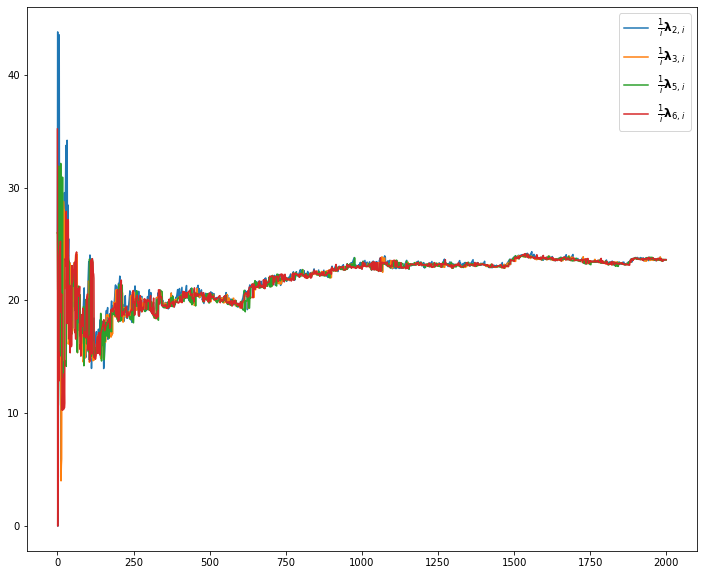

In [4]:
fileName = 'newnetwork'

randomized_learning(fileName,'load', alpha = 0, T = 2000, hyp = 1, user_subset = [1,2,4,5])

The last part is to confirm the consistency of the theoretical large deviation rate function $I(s)$ and its estimation $\hat I(s)$. The estimator is based on an importance sampling method for Markov additive processes (see [2], [3] for details). s_low and s_high are the minimum and maximum values of the slope of $\hat I(s)$, and s_num_pts is the number of points where $\hat I(s)$ is estimated. For each point, the estimator is based on the average of a number of trials, set as the trials parameter.

Number of nodes:  12
Asymp. conv. rate: 22.634715846915462
point  1
point  2
point  3
point  4
point  5
point  6
point  7
point  8
point  9
point  10
[[ 1.86490306e-02  1.16893424e-01  1.88782036e-02  1.84350559e-02
   1.70333864e-02  2.51072960e-02  2.20242530e-02  3.02305978e-02
   2.44774139e-02  2.31971373e-02  1.97407147e-02  1.45964881e-02]
 [ 1.57087819e-02  8.48025579e-02  1.13415745e-02  1.07661403e-02
   1.31328388e-02  1.89411407e-02  1.41409538e-02  2.09502446e-02
   1.57405007e-02  1.52392208e-02  1.53405057e-02  9.71902945e-03]
 [ 8.38272420e-03  4.99752208e-02  5.77938610e-03  5.52488104e-03
   7.24028164e-03  7.02235512e-03  7.99206011e-03  1.17922039e-02
   9.67794051e-03  1.04537671e-02  9.07153906e-03  4.69046177e-03]
 [ 1.45865387e-03  2.46986419e-02  3.93723508e-03  1.46734414e-03
   3.83272031e-03  2.27281751e-03  4.92818163e-03  4.78955884e-03
   4.00492849e-03  4.64410418e-03  2.88669870e-03  2.69682709e-03]
 [ 5.15032088e-04  6.45095930e-03  1.35364629e-03  1.0

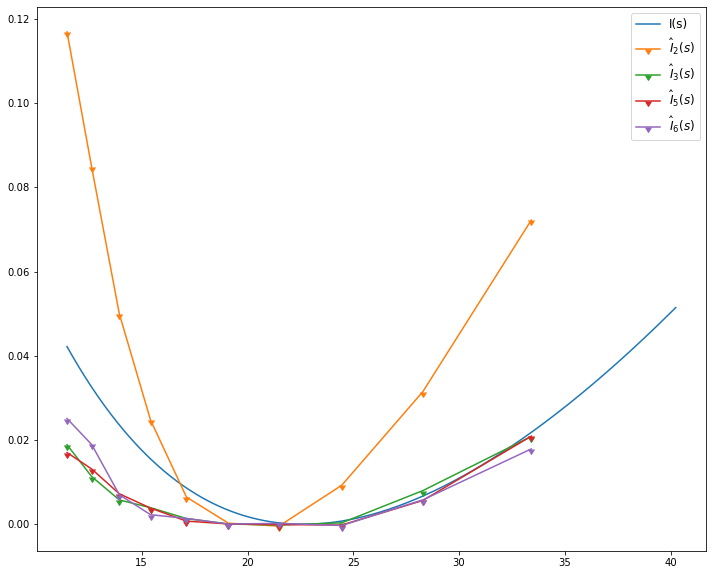

In [6]:
randomized_learning(fileName,'load', T = 2500, experiment = 'large_dev', s_low = -9e-3, s_high = 5e-3, s_num_pts = 10, trials = 100, user_subset = [1,2,4,5])

### References


[1] Y. Inan, M. Kayaalp, E. Telatar, and A. H. Sayed, “Social learning under randomized collaborations,” 2022 IEEE International Symposium on Information Theory (ISIT) (ISIT 2022), Espoo, Finland, June 2022.

[2] J. F. Collamore, “Importance sampling techniques for the multidimensional ruin problem for general markov additive sequences of random
vectors,” The Annals of Applied Probability, vol. 12, no. 1, pp. 382–421,
2002.

[3] I. Iscoe, P. Ney, and E. Nummelin, “Large deviations of uniformly
recurrent markov additive processes,” Advances in Applied Mathematics,
vol. 6, no. 4, pp. 373–412, 1985.


